<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xz/blob/main/coregister_xz.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  
<a href="https://github.com/WinetraubLab/coregister-xz/blob/main/coregister_xz.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
This notebook will compute the best plane fit based on photobleach lines.


In [1]:
# @title Optical Setup Inputs (Shouldn't Change)

# Line Positions
v_line_bias_mm = 700e-3
h_line_bias_mm = -400e-3
base_mm = 100e-3
v_lines_spacing = [-1, 0, 1] # Unitless, units will be added later in the code
h_lines_spacing = [-2, 0, 1, 2] # Unitless, units will be added later in the code

In [2]:
# @title Inputs (Cutting)

cut_position = "1" #@param [1,2,3,4]
cut_position = int(cut_position)
mirror = "False" #@param ["True","False"]
mirror = mirror == "True"

In [3]:
# @title Inputs (Fluorescence Image Points)

# On the fluorescence image, record which points are on every line (pixels)
# Lines show up from left to right on the flourescence image
fluorescence_image_points_on_line_pix = [
  [ [ 143, 0], [ 143, 1] ], # A few points on line 0 (left most line in image)
  [ [ 272, 0], [ 272, 1] ], # A few points on line 1 (next line from left)
  [ [ 412, 0], [ 412, 1] ], # ...
  [ [1359, 0], [1359, 1] ],
  [ [1492, 0], [1492, 1] ],
  [ [1625, 0], [1625, 1] ],
  [ [1894, 0], [1894, 1] ], # A few points on line 6 (right most line image)
  ]

if (len(fluorescence_image_points_on_line_pix) !=
    len(v_lines_spacing) + len(h_lines_spacing)):
    raise ValueError('Number of lines identified in the fluorescence_image should be equal to number of lines in template')

In [4]:
# @title Environment Setup

if not 'setup_env_coregister_xz' in globals():
  setup_env_coregister_xz = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/coregister-xz/
  %cd ./coregister-xz/

from plane.fit_plane import FitPlane
from plane.plot_fit_plane import plot_fit_plane
import numpy as np
import matplotlib.pyplot as plt

Cloning into 'coregister-xz'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 110 (delta 49), reused 78 (delta 23), pack-reused 0
Receiving objects: 100% (110/110), 45.28 KiB | 1.26 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/coregister-xz


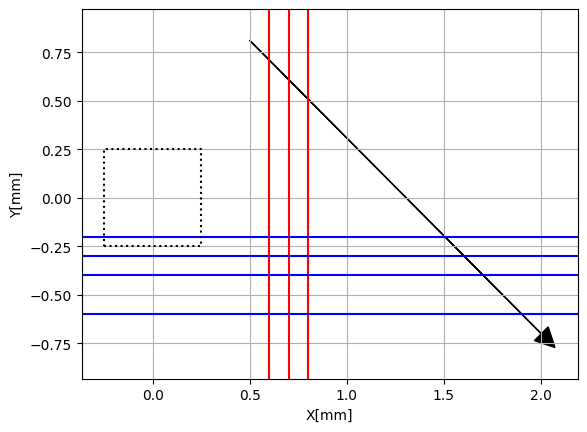

Fit Statistics
Pixel Size: |u| = 1.054um, |v| = 1.054um
Signed Distance from Origin: -0.926mm
X-Y Rotation: 45.17 degrees
Tilt: 0.00 degrees


In [5]:
# @title Do the work

# Create the base unit structure
v_photobleach_line_position_mm = np.array(v_lines_spacing) * base_mm + v_line_bias_mm
h_photobleach_line_position_mm = np.array(h_lines_spacing) * base_mm + h_line_bias_mm

# Combine v lines and h lines according to order
def combine(v_photobleach_line_position_mm, h_photobleach_line_position_mm,
            order='vh',flip_v=False, flip_h=False):
  if flip_v:
    v = np.flipud(v_photobleach_line_position_mm)
  else:
    v = v_photobleach_line_position_mm

  if flip_h:
    h = np.flipud(h_photobleach_line_position_mm)
  else:
    h = h_photobleach_line_position_mm

  if order == 'hv':
    photobleach_line_position_mm = np.concatenate((h, v), axis=0)
    photobleach_line_group = (['h'] * len(h)) + (['v'] * len(v))
  else:
    photobleach_line_position_mm = np.concatenate((v, h), axis=0)
    photobleach_line_group = (['v'] * len(v)) + (['h'] * len(h))

  return photobleach_line_position_mm, photobleach_line_group

if cut_position == 1:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='vh',flip_v=False, flip_h=True)
elif cut_position == 2:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='hv',flip_v=False, flip_h=False)
elif cut_position == 3:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='hv',flip_v=True, flip_h=False)
elif cut_position == 4:
  photobleach_line_position_mm, photobleach_line_group = combine(
      v_photobleach_line_position_mm, h_photobleach_line_position_mm,
      order='vh',flip_v=False, flip_h=False)

# Flip lines based on mirror status
fluorescence_image_points_on_line_pix = np.array(fluorescence_image_points_on_line_pix)
if mirror:
  fluorescence_image_points_on_line_pix = np.flipud(fluorescence_image_points_on_line_pix)


# Fit & Plot
fp = FitPlane(
    fluorescence_image_points_on_line_pix,
    photobleach_line_position_mm,
    photobleach_line_group)
plot_fit_plane(fp,
  v_photobleach_line_position_mm,
  h_photobleach_line_position_mm, reverse_plot=mirror)

# Print stats
print('Fit Statistics')
print("Pixel Size: |u| = %.3fum, |v| = %.3fum" %
  (fp.u_norm_mm()*1e3, fp.v_norm_mm()*1e3 ) )
print("Signed Distance from Origin: %.3fmm" % fp.distance_from_origin_mm())
print("X-Y Rotation: %.2f degrees" % fp.xy_rotation_deg())
print("Tilt: %.2f degrees" % fp.tilt_deg())